Loading the data and initial observations

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, zscore
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, mutual_info_regression

from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [19]:
#reading an excel file
orders = pd.read_csv('superstore_sales.csv')

In [20]:
#view top 5 records
orders.head()

,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,...,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,year
0,AG-2011-2040,01-01-2011,06-01-2011,Standard Class,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,Africa,...,Office Supplies,Storage,"Tenex Lockers, Blue",408,2,0.0,106.140,35.46,Medium,2011
1,IN-2011-47883,01-01-2011,08-01-2011,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,...,Office Supplies,Supplies,"Acme Trimmer, High Speed",120,3,0.1,36.036,9.72,Medium,2011
2,HU-2011-1220,01-01-2011,05-01-2011,Second Class,Annie Thurman,Consumer,Budapest,Hungary,EMEA,EMEA,...,Office Supplies,Storage,"Tenex Box, Single Width",66,4,0.0,29.640,8.17,High,2011
3,IT-2011-3647632,01-01-2011,05-01-2011,Second Class,Eugene Moren,Home Office,Stockholm,Sweden,EU,North,...,Office Supplies,Paper,"Enermax Note Cards, Premium",45,3,0.5,-26.055,4.82,High,2011
4,IN-2011-47883,01-01-2011,08-01-2011,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,...,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",114,5,0.1,37.770,4.70,Medium,2011


In [21]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        51290 non-null  object 
 1   order_date      51290 non-null  object 
 2   ship_date       51290 non-null  object 
 3   ship_mode       51290 non-null  object 
 4   customer_name   51290 non-null  object 
 5   segment         51290 non-null  object 
 6   state           51290 non-null  object 
 7   country         51290 non-null  object 
 8   market          51290 non-null  object 
 9   region          51290 non-null  object 
 10  product_id      51290 non-null  object 
 11  category        51290 non-null  object 
 12  sub_category    51290 non-null  object 
 13  product_name    51290 non-null  object 
 14  sales           51290 non-null  object 
 15  quantity        51290 non-null  int64  
 16  discount        51290 non-null  float64
 17  profit          51290 non-null 

Outof 21 columns, 5 are numerical and 16 are objects type.
Now analyzing object datas, we find that we dont need order_id, order_date, ship_date, product_id, and order_priority. That is why w remove all of them.

In [22]:
#removing columns that we dont need
orders.drop(['order_id', 'order_date', 'ship_date', 'product_id','order_priority'], axis=1, inplace=True)

In [23]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ship_mode      51290 non-null  object 
 1   customer_name  51290 non-null  object 
 2   segment        51290 non-null  object 
 3   state          51290 non-null  object 
 4   country        51290 non-null  object 
 5   market         51290 non-null  object 
 6   region         51290 non-null  object 
 7   category       51290 non-null  object 
 8   sub_category   51290 non-null  object 
 9   product_name   51290 non-null  object 
 10  sales          51290 non-null  object 
 11  quantity       51290 non-null  int64  
 12  discount       51290 non-null  float64
 13  profit         51290 non-null  float64
 14  shipping_cost  51290 non-null  float64
 15  year           51290 non-null  int64  
dtypes: float64(3), int64(2), object(11)
memory usage: 6.3+ MB


The column size has been reduced to 15.
Now first lets deal with duplicate and missing entries.

In [24]:
orders.duplicated().sum()

1

In [25]:
orders.drop_duplicates(inplace=True)

In [26]:
orders.isna().sum()

ship_mode        0
customer_name    0
segment          0
state            0
country          0
market           0
region           0
category         0
sub_category     0
product_name     0
sales            0
quantity         0
discount         0
profit           0
shipping_cost    0
year             0
dtype: int64

No null values! Double check!

In [27]:
orders.sample(10)

,ship_mode,customer_name,segment,state,country,market,region,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,year
33186,Standard Class,David Kendrick,Corporate,Brandenburg,Germany,EU,Central,Technology,Machines,"StarTech Calculator, Red",260,7,0.00,38.8500,34.13,2013
23573,Standard Class,Russell Applegate,Consumer,Shandong,China,APAC,North Asia,Office Supplies,Fasteners,"Stockwell Push Pins, Assorted Sizes",11,1,0.00,2.7300,0.94,2013
15393,Standard Class,Yana Sorensen,Corporate,Pays de la Loire,France,EU,Central,Technology,Accessories,"Logitech Memory Card, USB",207,2,0.00,33.1200,21.30,2012
22318,Second Class,Julia West,Consumer,Lusaka,Zambia,Africa,Africa,Furniture,Furnishings,"Deflect-O Clock, Durable",189,4,0.00,60.4800,4.93,2013
38650,Standard Class,Clay Ludtke,Consumer,Grand Casablanca,Morocco,Africa,Africa,Office Supplies,Fasteners,"OIC Rubber Bands, Assorted Sizes",29,2,0.00,9.2400,1.24,2014
12428,Standard Class,Lori Olson,Corporate,Jakarta,Indonesia,APAC,Southeast Asia,Technology,Machines,"Panasonic Receipt Printer, White",594,6,0.17,-28.6362,58.49,2012
15387,First Class,Jason Klamczynski,Corporate,Sinaloa,Mexico,LATAM,North,Furniture,Chairs,"Office Star Rocking Chair, Set of Two",305,4,0.20,11.4080,30.63,2012
50227,Same Day,Kelly Lampkin,Corporate,Ho Chí Minh City,Vietnam,APAC,Southeast Asia,Office Supplies,Supplies,"Fiskars Letter Opener, Easy Grip",139,6,0.17,28.3914,14.88,2014
30672,First Class,Rob Beeghly,Consumer,Catalonia,Spain,EU,South,Technology,Phones,"Nokia Headset, Full Size",335,5,0.10,-29.8500,39.86,2013
26282,Standard Class,Charles Sheldon,Corporate,Sumatera Selatan,Indonesia,APAC,Southeast Asia,Office Supplies,Art,"Stanley Pens, Fluorescent",17,2,0.27,-2.0874,0.72,2013


Now, let's check the distribution of sales.

In [28]:
orders.describe()

,quantity,discount,profit,shipping_cost,year
count,51289.000000,51289.000000,51289.000000,51289.000000,51289.000000
mean,3.476554,0.142899,28.642735,26.376405,2012.777184
std,2.278788,0.212272,174.425668,57.297255,1.098929
min,1.000000,0.000000,-6599.978000,0.000000,2011.000000
25%,2.000000,0.000000,0.000000,2.610000,2012.000000
50%,3.000000,0.000000,9.240000,7.790000,2013.000000
75%,5.000000,0.200000,36.810000,24.450000,2014.000000
max,14.000000,0.850000,8399.976000,933.570000,2014.000000


In [29]:
object_columns = orders.select_dtypes(include=['object']).columns
print("Object type columns:")
print(object_columns)

Object type columns:
Index(['ship_mode', 'customer_name', 'segment', 'state', 'country', 'market',
       'region', 'category', 'sub_category', 'product_name', 'sales'],
      dtype='object')


In [30]:
num_columns = orders.select_dtypes(include=['int64','float64']).columns
print("Numerical type columns:")
print(num_columns)

Numerical type columns:
Index(['quantity', 'discount', 'profit', 'shipping_cost', 'year'], dtype='object')


Now we remove he outliers from the numerical columns in the dataframe.

In [125]:
# Identify outliers using the IQR method
def identify_outliers_iqr(df):
    col='shipping_cost'
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_filtered_df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return outliers_filtered_df

outliers_f_d = identify_outliers_iqr(orders)
print("Outliers:\n", outliers_f_d)

Outliers:
             ship_mode     customer_name      segment             state  \
0      Standard Class   Toby Braunhardt     Consumer       Constantine   
1      Standard Class       Joseph Holt     Consumer   New South Wales   
2        Second Class     Annie Thurman     Consumer          Budapest   
3        Second Class      Eugene Moren  Home Office         Stockholm   
4      Standard Class       Joseph Holt     Consumer   New South Wales   
...               ...               ...          ...               ...   
51285  Standard Class        Erica Bern    Corporate        California   
51286  Standard Class         Liz Preis     Consumer  Souss-Massa-Draâ   
51287    Second Class  Charlotte Melton     Consumer           Managua   
51288  Standard Class     Tamara Dahlen     Consumer         Chihuahua   
51289  Standard Class     Jill Matthias     Consumer          Colorado   

             country  market   region         category sub_category  \
0            Algeria  Africa 

ship_mode        0
customer_name    0
segment          0
state            0
country          0
market           0
region           0
category         0
sub_category     0
product_name     0
sales            0
quantity         0
discount         0
profit           0
shipping_cost    0
year             0
dtype: int64

### Calculate Z-scores for each numerical column
z_scores = orders[num_columns].apply(zscore)

### Identify outliers as values with a Z-score greater than 3 or less than -3
outliers_zscore = (z_scores > 3) | (z_scores < -3)
print("Outliers (Z-score method):\n", orders[outliers_zscore.any(axis=1)])

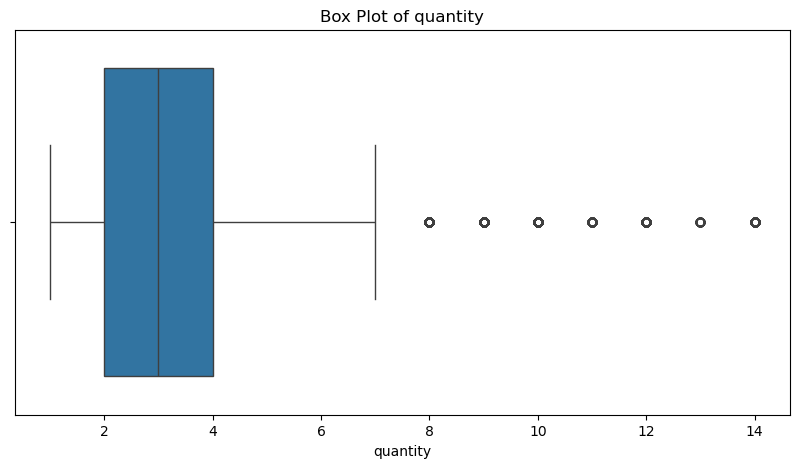

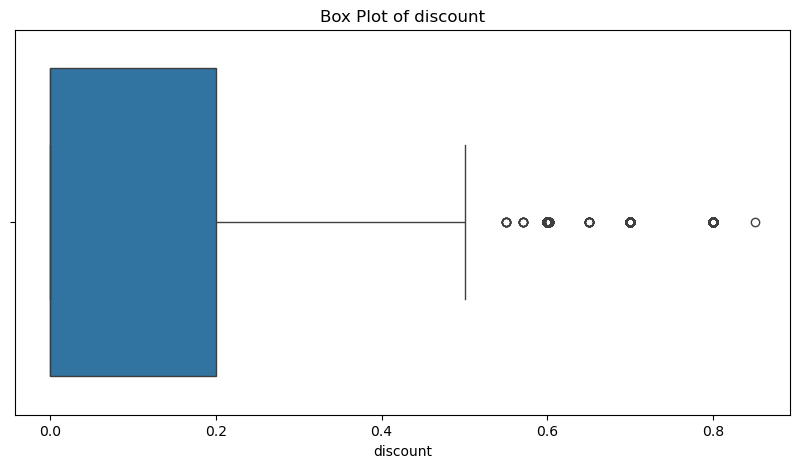

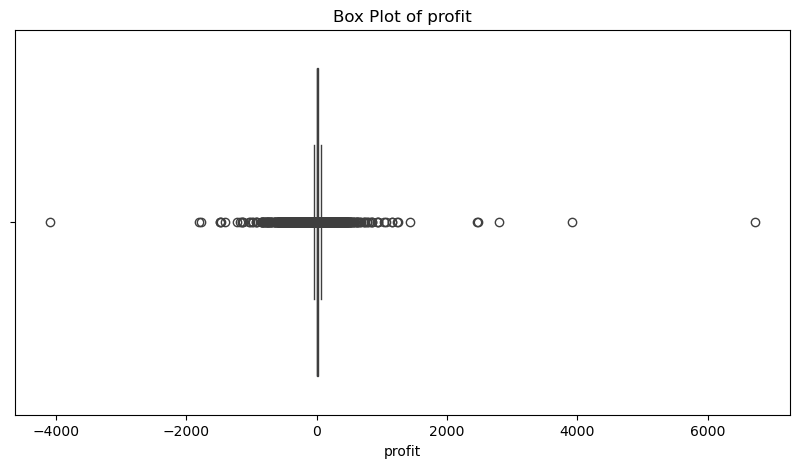

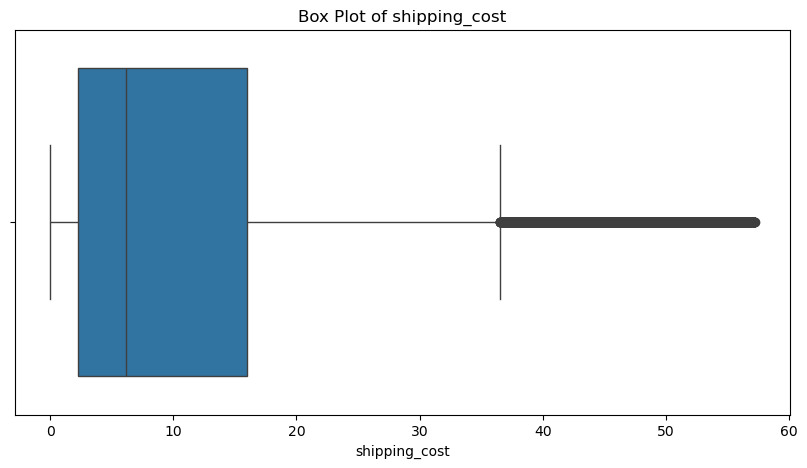

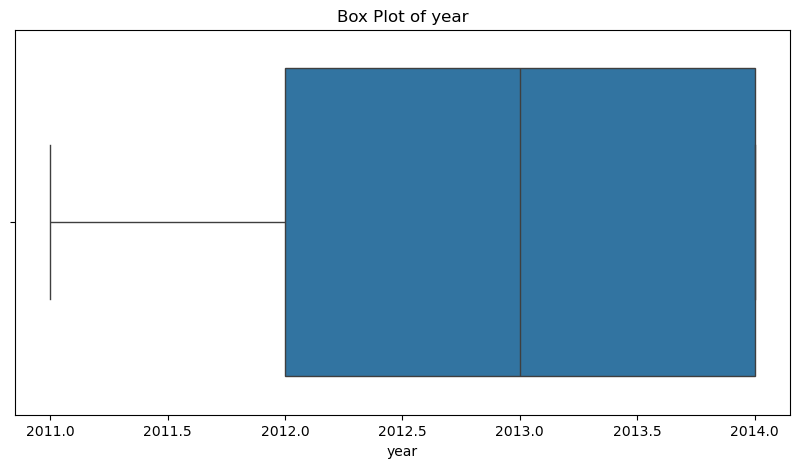

In [126]:
# Plot box plots for each numerical column
for col in orders.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=outliers_f_d[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()

In [127]:
outliers_f_d.describe()

,quantity,discount,profit,shipping_cost,year
count,45380.000000,45380.000000,45380.000000,45380.000000,45380.000000
mean,3.278493,0.147900,12.221091,11.438861,2012.779859
std,2.163874,0.217987,89.348610,12.869410,1.098238
min,1.000000,0.000000,-4088.376000,0.000000,2011.000000
25%,2.000000,0.000000,-0.009750,2.260000,2012.000000
50%,3.000000,0.000000,7.680000,6.160000,2013.000000
75%,4.000000,0.200000,26.641500,15.970000,2014.000000
max,14.000000,0.850000,6719.980800,57.200000,2014.000000


In [128]:
outliers_f_d['ship_mode'].value_counts()

ship_mode
Standard Class    28145
Second Class       8901
First Class        6139
Same Day           2195
Name: count, dtype: int64

EDA

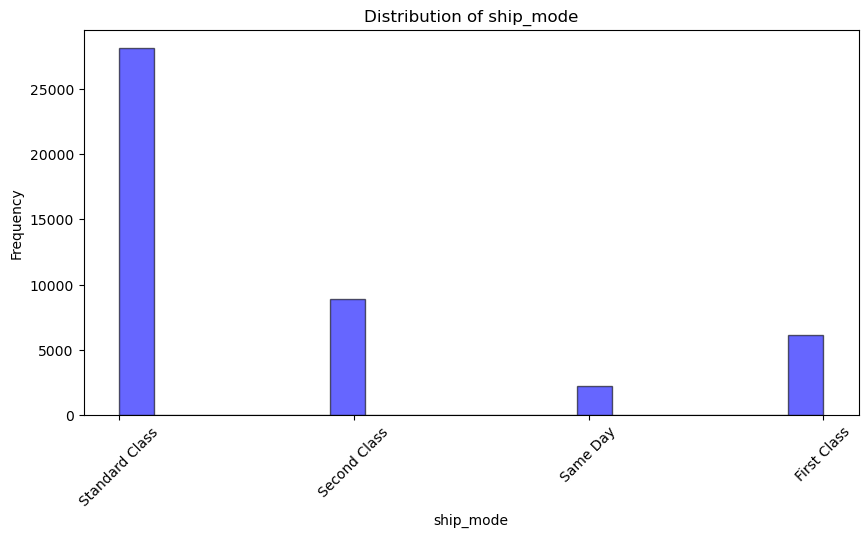

In [129]:
# for col in orders.columns:
col = 'ship_mode'
plt.figure(figsize=(10, 5))
plt.title(f"Distribution of {col}")
plt.hist(outliers_f_d[col], bins=20, alpha=0.6, color='b', edgecolor='black')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


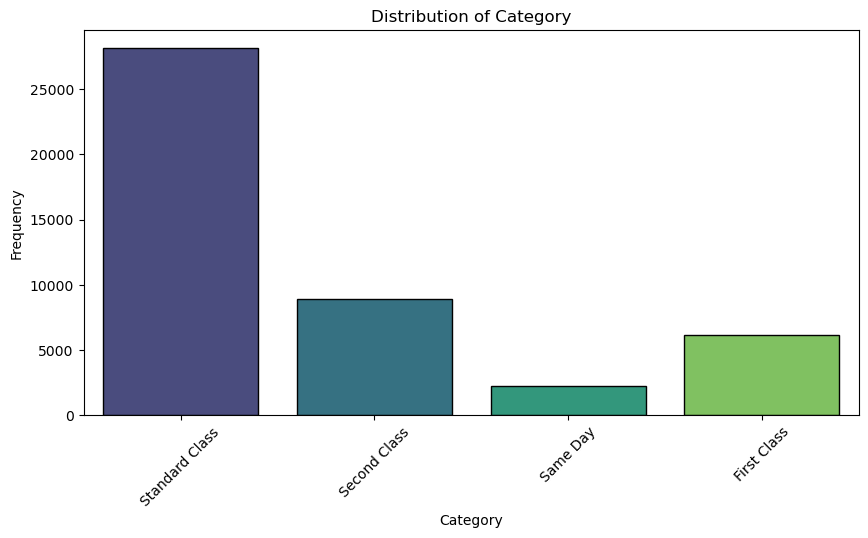

In [130]:
plt.figure(figsize=(10, 5))
sns.countplot(x=col, data=outliers_f_d, palette='viridis', edgecolor='black')
plt.title('Distribution of Category')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Lets Resample

OverSample

In [131]:
#Separate majority and minority classes
ship_mode_majority = outliers_f_d[outliers_f_d['ship_mode']=='Standard Class']
ship_mode_minority = outliers_f_d[outliers_f_d['ship_mode'].isin(['Same Day', 'Second Class', 'First Class'])]

#Oversample minority classes
ship_mode_minority_oversampled = resample(ship_mode_minority, 
                                   replace=True,     # Sample with replacement
                                   n_samples=len(ship_mode_majority),    # Match number in majority class
                                   random_state=42)  # Reproducible results

# Combine majority class with oversampled minority class
df_oversampled = pd.concat([ship_mode_majority, ship_mode_minority_oversampled])

print("Oversampled DataFrame:\n", df_oversampled['ship_mode'].value_counts())

Oversampled DataFrame:
 ship_mode
Standard Class    28145
Second Class      14528
First Class       10051
Same Day           3566
Name: count, dtype: int64


In [132]:
#Separate majority and minority classes
ship_mode_majority = df_oversampled[df_oversampled['ship_mode'].isin(['First Class'])]
ship_mode_minority_sd = df_oversampled[df_oversampled['ship_mode']=='Same Day']

#Oversample minority classes
ship_mode_minority_oversampled_sd = resample(ship_mode_minority_sd, 
                                   replace=True,     # Sample with replacement
                                   n_samples=len(ship_mode_majority),    # Match number in majority class
                                   random_state=42)  # Reproducible results

# Combine majority class with oversampled minority class
df_oversampled_sd = pd.concat([ship_mode_majority, ship_mode_minority_oversampled_sd])

print("Oversampled DataFrame:\n", df_oversampled_sd['ship_mode'].value_counts())

# Combine the remaining original DataFrame with the undersampled majority class
df_combined = pd.concat([df_oversampled, df_oversampled_sd])

print("Combined DataFrame:\n", df_combined['ship_mode'].value_counts())

Oversampled DataFrame:
 ship_mode
First Class    10051
Same Day       10051
Name: count, dtype: int64
Combined DataFrame:
 ship_mode
Standard Class    28145
First Class       20102
Second Class      14528
Same Day          13617
Name: count, dtype: int64


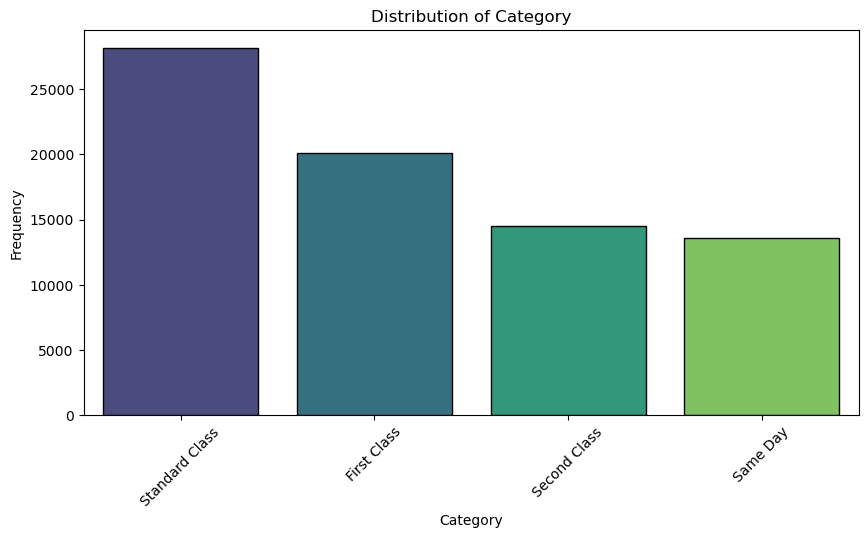

In [133]:
plt.figure(figsize=(10, 5))
sns.countplot(x=col, data=df_combined, palette='viridis', edgecolor='black')
plt.title('Distribution of Category')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

UnderSample

In [134]:
#Separate majority and minority classes
ship_mode_majority = df_combined[df_combined['ship_mode'].isin(['Standard Class'])]
ship_mode_minority = df_combined[df_combined['ship_mode']=='Same Day']

# Undersample majority class
ship_mode_majority_undersampled = resample(ship_mode_majority, 
                                    replace=False,    # Sample without replacement
                                    n_samples=len(ship_mode_minority),    # Match number in minority class
                                    random_state=42)  # Reproducible results

# Combine undersampled majority class with minority class
df_undersampled = pd.concat([ship_mode_majority_undersampled, ship_mode_minority])

print("Undersampled DataFrame:\n", df_undersampled['ship_mode'].value_counts())

# Remove original majority class samples from the original DataFrame
df_remaining = df_combined[df_combined['ship_mode'] != 'Standard Class']

# Combine the remaining original DataFrame with the undersampled majority class
df_combined_un = pd.concat([df_remaining, df_undersampled])

print("Combined DataFrame:\n", df_combined_un['ship_mode'].value_counts())

Undersampled DataFrame:
 ship_mode
Standard Class    13617
Same Day          13617
Name: count, dtype: int64
Combined DataFrame:
 ship_mode
Same Day          27234
First Class       20102
Second Class      14528
Standard Class    13617
Name: count, dtype: int64


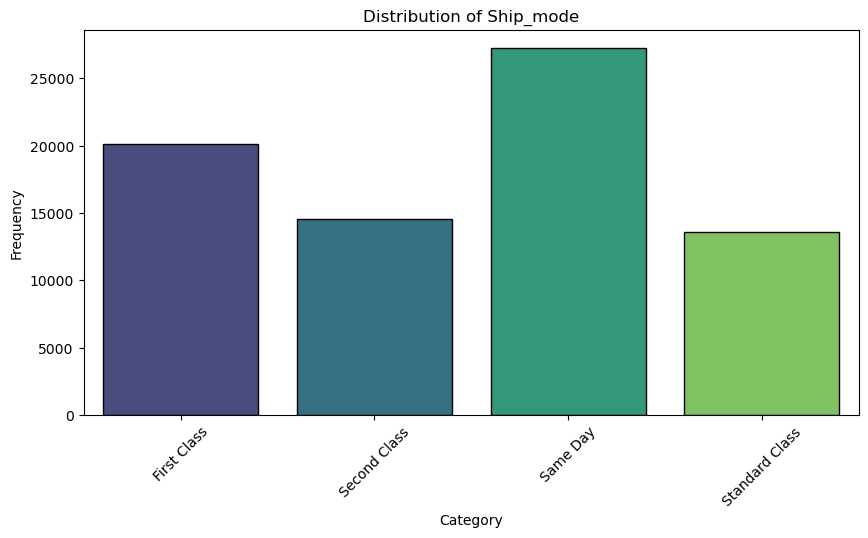

In [135]:
plt.figure(figsize=(10, 5))
sns.countplot(x=col, data=df_combined_un, palette='viridis', edgecolor='black')
plt.title('Distribution of Ship_mode')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [136]:
df_combined_un.head()

,ship_mode,customer_name,segment,state,country,market,region,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,year
46881,First Class,Toby Carlisle,Consumer,Rhineland-Palatinate,Germany,EU,Central,Office Supplies,Supplies,"Stiletto Ruler, Steel",43,3,0.0,21.4200,10.92,2014
2544,Second Class,Steven Ward,Corporate,Groningen,Netherlands,EU,Central,Furniture,Furnishings,"Tenex Stacking Tray, Durable",101,5,0.2,4.9200,6.30,2011
16140,Second Class,Rick Huthwaite,Home Office,California,United States,US,West,Office Supplies,Storage,"Personal Filing Tote with Lid, Black/Gray",16,1,0.0,4.3428,1.95,2012
35845,First Class,Frank Olsen,Consumer,Gansu,China,APAC,North Asia,Office Supplies,Envelopes,"GlobeWeis Clasp Envelope, Set of 50",50,5,0.0,0.0000,0.46,2014
33844,First Class,Aaron Smayling,Corporate,North Carolina,United States,US,South,Office Supplies,Binders,Avery Recycled Flexi-View Covers for Binding S...,29,6,0.7,-21.1596,5.35,2014


In [137]:
df_combined_un.describe()

,quantity,discount,profit,shipping_cost,year
count,75481.000000,75481.000000,75481.000000,75481.000000,75481.000000
mean,3.204608,0.151378,10.926353,12.805344,2012.793498
std,2.135463,0.222064,114.490774,13.474247,1.100936
min,1.000000,0.000000,-4088.376000,0.000000,2011.000000
25%,2.000000,0.000000,-0.028200,2.820000,2012.000000
50%,3.000000,0.000000,6.960000,7.450000,2013.000000
75%,4.000000,0.200000,22.788000,18.480000,2014.000000
max,14.000000,0.850000,6719.980800,57.200000,2014.000000


# Normalization and Scaling

In [166]:
# Select only the numerical columns
numerical_cols = df_combined_un.select_dtypes(include=['int64', 'float64']).columns

# Initialize the StandardScaler
std_scaler = MinMaxScaler()

# Fit and transform the numerical columns
df_combined_un[numerical_cols] = std_scaler.fit_transform(df_combined_un[numerical_cols])

print(df_combined_un.head())

          ship_mode   customer_name      segment                 state  \
46881   First Class   Toby Carlisle     Consumer  Rhineland-Palatinate   
2544   Second Class     Steven Ward    Corporate             Groningen   
16140  Second Class  Rick Huthwaite  Home Office            California   
35845   First Class     Frank Olsen     Consumer                 Gansu   
33844   First Class  Aaron Smayling    Corporate        North Carolina   

             country market      region         category sub_category  \
46881        Germany     EU     Central  Office Supplies     Supplies   
2544     Netherlands     EU     Central        Furniture  Furnishings   
16140  United States     US        West  Office Supplies      Storage   
35845          China   APAC  North Asia  Office Supplies    Envelopes   
33844  United States     US       South  Office Supplies      Binders   

                                            product_name sales  quantity  \
46881                              Stile

# Train_Test_Split

In [167]:
# Separate features and target
X = df_combined_un.drop('profit', axis=1)
y = df_combined_un['profit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Selection and Extraction

In [209]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

# One-hot encode categorical features
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Align the columns of the test set with the training set
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [198]:
print("Encoded Training Data:\n", X_train_encoded.head())
print("Encoded Testing Data:\n", X_test_encoded.head())

Encoded Training Data:
        ship_mode  customer_name  segment  state  country  market  region  \
26404          1            500        1    308       58       3       5   
21286          1            566        0    461       93       1       0   
36539          1            547        0    791       17       5      10   
396            0            530        1    433       57       0      11   
3194           3            551        1     28       59       3       5   

       category  sub_category  product_name  sales  quantity  discount  \
26404         1             2          2844    514  0.000000  0.000000   
21286         2             6          1638    492  0.000000  0.823529   
36539         1             3           422    329  0.076923  0.705882   
396           1            15          1947    914  0.307692  0.552941   
3194          0             9          3155    111  0.000000  0.000000   

       shipping_cost      year  
26404       0.327972  0.666667  
21286   

In [205]:

# Feature selection
X_train_selected = SelectKBest(mutual_info_regression, k=10).fit_transform(X_train_encoded, y_train)

In [206]:
dataframe = pd.DataFrame(X_train_selected)

In [207]:
dataframe.head()

,0,1,2,3,4,5,6,7,8,9
0,500.0,308.0,58.0,5.0,2.0,2844.0,514.0,0.000000,0.000000,0.327972
1,566.0,461.0,93.0,0.0,6.0,1638.0,492.0,0.000000,0.823529,0.174650
2,547.0,791.0,17.0,10.0,3.0,422.0,329.0,0.076923,0.705882,0.009790
3,530.0,433.0,57.0,11.0,15.0,1947.0,914.0,0.307692,0.552941,0.084965
4,551.0,28.0,59.0,5.0,9.0,3155.0,111.0,0.000000,0.000000,0.156294


In [208]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the LinearRegression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_selected, y_train)

# Transform the test data using the same feature selection
X_test_selected = SelectKBest(mutual_info_regression, k=10).fit_transform(X_test_encoded, y_test)

# Predict on the test data
y_pred = model.predict(X_test_selected)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.00011327973352792305
R^2 Score: -0.19640276307877214


Interpreting MSE and R² Score
Mean Squared Error (MSE):

MSE measures the average squared difference between the actual and predicted values.
Lower MSE values indicate better model performance, as it means the predictions are closer to the actual values.
R-squared (R²) Score:

R² measures the proportion of the variance in the dependent variable that is predictable from the independent variables.
R² values range from 0 to 1, where 1 indicates perfect prediction and 0 indicates that the model does not explain any of the variance.
Improving Model Performance
If the model's performance is not satisfactory (high MSE and low R²), here are some general strategies to improve it:

Feature Engineering:

Add new features that may have predictive power.
Remove irrelevant or redundant features.
Transform features (e.g., log transformation, polynomial features).
Model Selection:

Try different algorithms (e.g., linear regression, decision trees, random forests, gradient boosting).
Use cross-validation to select the best model.
Hyperparameter Tuning:

Use techniques like Grid Search or Random Search to find the optimal hyperparameters for your model.
Data Preprocessing:

Handle missing values appropriately.
Normalize or standardize features if necessary.
Regularization:

Apply regularization techniques (e.g., Lasso, Ridge) to prevent overfitting.
Increase Training Data:

Collect more data if possible, as more data can help the model learn better.
Ensemble Methods:

Combine predictions from multiple models to improve overall performance.